#  Predictive Classification Models

##  Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.set()

# Dimensionality reduction
from sklearn.decomposition import PCA

# Pickle
import joblib

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

In [2]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load data

In [3]:
#  Load cleaned data
df = pd.read_csv('../raw_data/clean_data.csv')
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,FATAL,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,1999,January,Monday,9.0,0,2.0,Right turn,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1992.0,1.0,F,33.0,Driver,Injury,Safety device used,Motor Vehicle Driver,2890
1,1999,January,Monday,9.0,0,2.0,Right turn,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1992.0,1.0,F,70.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,2890
2,1999,January,Monday,20.0,0,1.0,Ran off left shoulder,Intersection with parking lot entrance,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1988.0,1.0,F,38.0,Driver,Injury,Safety device used,Motor Vehicle Driver,4332
3,1999,January,Monday,5.0,0,2.0,Hit a moving object,At an intersection,Raining,Wet,...,Other trucks and vans,1995.0,1.0,M,34.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,5053
4,1999,January,Monday,5.0,0,2.0,Hit a moving object,At an intersection,Raining,Wet,...,Other trucks and vans,1995.0,2.0,M,30.0,"Front row, right outboard",No Injury,Safety device used,Motor Vehicle Passenger,5053


In [4]:
df.columns

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'FATAL', 'C_VEHS', 'C_CONF',
       'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE',
       'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER', 'C_CASE'],
      dtype='object')

In [5]:
df.shape

(3817613, 23)

In [6]:
# Shuffle the dataset
df = df.sample(frac =1).reset_index(drop = True)

## Class distribution

0    98.39
1     1.61
Name: FATAL, dtype: float64

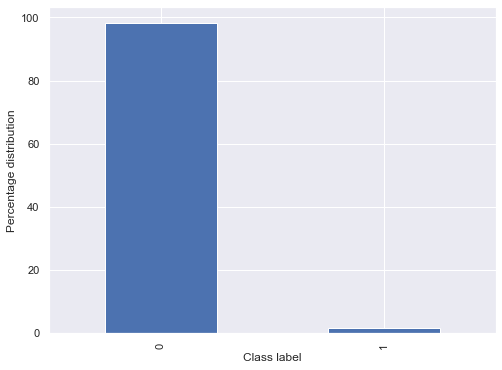

In [7]:
class_dis = (df.FATAL.value_counts()/len(df)*100)
class_dis.plot(kind = 'bar', figsize = (8,6))
plt.xlabel('Class label')
plt.ylabel('Percentage distribution')
round(class_dis,2)

## Reduce the dataset

Since the dataset is very large to fit in a small laptop memory, training the entire dataset on a laptop will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [8]:
X1, X2, y1, y2 = train_test_split(df,df.FATAL, test_size = 0.01, random_state = 42, stratify = df.FATAL)

In [9]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (3779436, 23) (3779436,)
Small subset size: (38177, 23) (38177,)


In [10]:
# Save the small subset as csv file
X2.to_csv('../data/collision.csv', index = False)

##   Prepare data for machine learning

In [11]:
# Reload data
df_small = pd.read_csv('../data/collision.csv')

In [12]:
# Feature matrix and class label
X, y = df_small.drop(['P_ID', 'V_ID', 'FATAL'], axis = 1), df_small['FATAL']

In [13]:
print('Size of the data:', X.shape, y.shape)

Size of the data: (38177, 20) (38177,)


## Create a Test Set

We now split the into $80\%$ training set and $20\%$ test set in a stratify fashion

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [15]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (30541, 20) (30541,)
Test set size: (7636, 20) (7636,)


In [16]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('*********************************')
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    98.395599
1     1.604401
Name: FATAL, dtype: float64
*********************************
Test set class distribution:
 0    98.389209
1     1.610791
Name: FATAL, dtype: float64


##  Data Pre-processing

In [17]:
# List of categorical attributes
cat_subset = list(X_train.select_dtypes('O'))

# List of numerical attributes
num_subset = list(X_train.select_dtypes('number'))

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_subset]

# Standardize the numerical attributes
num_attribs = [([num], StandardScaler()) for num in num_subset]

# Build a dataframe mapper pipeline
mapper = DataFrameMapper(cat_attribs + num_attribs)

# Fit transform the training set
X_train_scale = mapper.fit_transform(X_train)

# Only transform the training set
X_test_scale = mapper.transform(X_test)

In [18]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scale.shape)
print('Test set size after pre-processing:', X_test_scale.shape)

Training set size after pre-processing: (30541, 129)
Test set size after pre-processing: (7636, 129)


In [19]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# Model Selection by Cross-Validation Predictions

In this section, we train three models, Logistic Regression, Random Forest classifier, and XGBoost on the imbalanced dataset. As we shall see below, the overall accuracy of the model is not a good  performance measure for imbalanced datasets because it is bias towards the majority (negative) class. Therefore, we shall select and optimize the model with the best area under the precision-recall (AUPR) Curve. 

## 1. Logistic Regression

In [20]:
log_clf = LogisticRegression()                         
model_selection_cv(log_clf, X_train_scale, y_train, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.989751 (0.001296)
AUROC: 0.877049
AUPRC: 0.494043
Predicted classes: [0 1]
Confusion matrix:
 [[30047     4]
 [  309   181]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     30051
           1       0.98      0.37      0.54       490

    accuracy                           0.99     30541
   macro avg       0.98      0.68      0.77     30541
weighted avg       0.99      0.99      0.99     30541

****************************************************************************


##  2. Random Forest Classifier

In [21]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model_selection_cv(rf_clf, X_train_scale, y_train, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.989490 (0.001205)
AUROC: 0.751213
AUPRC: 0.415561
Predicted classes: [0 1]
Confusion matrix:
 [[30049     2]
 [  319   171]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     30051
           1       0.99      0.35      0.52       490

    accuracy                           0.99     30541
   macro avg       0.99      0.67      0.76     30541
weighted avg       0.99      0.99      0.99     30541

****************************************************************************


## 3. XGBoost

In [22]:
xgb_model = xgb.XGBClassifier(random_state = 42)
model_selection_cv(xgb_model, X_train_scale, y_train, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.989817 (0.001324)
AUROC: 0.878871
AUPRC: 0.493899
Predicted classes: [0 1]
Confusion matrix:
 [[30051     0]
 [  311   179]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     30051
           1       1.00      0.37      0.54       490

    accuracy                           0.99     30541
   macro avg       0.99      0.68      0.76     30541
weighted avg       0.99      0.99      0.99     30541

****************************************************************************


#  Hyperparameter Tuning and Cost Sensitive Method

 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [23]:
# Class ratio of the negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

61.32857142857143

## 1. Logistic Regression

In [24]:
# Range of hyperparameters
param_grid = {'C': [2**(-5), 2**(-3), 2**(-1), 2**(0), 2**(1)], 
             'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
                             
# Grid search
gsearch_log = GridSearchCV(LogisticRegression(),param_grid, cv = 5,
                           scoring = 'roc_auc',verbose =1, n_jobs = -1)
                                
# Fit the  training set
gsearch_log.fit(X_train_scale, y_train)

print('Grid search best AUC score:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s


Grid search best AUC score: 0.8826712432878625
Grid search best parameters: {'C': 0.03125, 'class_weight': {0: 1, 1: 3}}


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   16.5s finished


In [25]:
# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../trained_models/log_clf.pkl')

['../trained_models/log_clf.pkl']

## 2. Random Forest

In [26]:
# Range of hyperparameters
params = {'max_features': ['sqrt', 'log2'], 'class_weight': ['balanced', 'balanced_subsample',
          {0: 1, 1: 2}, {0: 1, 1: class_ratio}]}

# Randomized search
rf_clf = RandomForestClassifier(n_estimators = 2000, min_samples_leaf = 10, random_state = 42)           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                random_state = 42, verbose = 1)  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scale, y_train)

print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 20.1min finished


Randomized search best AUC score: 0.8886471290196686
Randomized search best hyperparameters: {'max_features': 'log2', 'class_weight': {0: 1, 1: 2}}


In [27]:
# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../trained_models/rf_clf.pkl')

['../trained_models/rf_clf.pkl']

## 3. XGBoost

In [28]:
# Range of hyperparameters
params = {'max_depth': range(3,10,2), 'min_child_weight': range(1,6,2),
         'subsample':[i/10 for i in range(5,9)],
         'colsample_bytree': [i/10 for i in range(5,9)]}

# Randomized search
xgb_model = xgb.XGBClassifier(n_estimators = 2000, random_state = 42,
                              scale_pos_weight = class_ratio, learning_rate = 0.1)
rsearch_xgb = RandomizedSearchCV(estimator = xgb_model, param_distributions = params, 
                                  scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                  random_state = 42, verbose = 1)  
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scale, y_train)

print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 98.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 109.5min finished


Randomized search best AUC score: 0.8588936297827746
Randomized search best hyperparameters: {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 9, 'colsample_bytree': 0.5}


In [29]:
# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../trained_models/xgb_clf.pkl')

['../trained_models/xgb_clf.pkl']

# Resampling Methods

In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## 1. Under sampling of the majority class

In undersampling, we reduce the majority class such that it matches the minority class

In [30]:
# Undersample the majority class
und = RandomUnderSampler(ratio = 'majority', random_state = 42)
X_train_scale_und, y_train_und = und.fit_sample(X_train_scale, y_train)

In [31]:
print('Undersampled training data size:', X_train_scale_und.shape, y_train_und.shape)

Undersampled training data size: (980, 129) (980,)


In [32]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [30051   490]
Undersampled training set class distribution: [490 490]


- We can see that the majority class in the training set has been undersampled

- We now have equal class distribution. Note that the test set is not resampled

### Random Forest cross-validation on the undersampled dataset

In [43]:
rf_und = rsearch_rf.best_estimator_ # from randomized search
model_selection_cv(rf_und, X_train_scale_und, y_train_und, cv_fold=5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.705102 (0.033441)
AUROC: 0.859775
AUPRC: 0.877484
Predicted classes: [0 1]
Confusion matrix:
 [[239 251]
 [ 38 452]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.49      0.62       490
           1       0.64      0.92      0.76       490

    accuracy                           0.71       980
   macro avg       0.75      0.71      0.69       980
weighted avg       0.75      0.71      0.69       980

****************************************************************************


## 2. Synthetic Minority Over Sampling Technique (SMOTE)

In SMOTE, we generate synthetic oberservations to match the minority class

In [34]:
# Oversample the minority class
sm = SMOTE(ratio = 'minority', random_state = 42)
X_train_scale_ovsm, y_train_ovsm = sm.fit_sample(X_train_scale, y_train)

In [35]:
print('SMOTE training data size:', X_train_scale_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (60102, 129) (60102,)


In [36]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [30051   490]
SMOTE resampled training set class distribution: [30051 30051]


- Similarly,  SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

###  Random Forest cross-validation in the SMOTE dataset

In [41]:
rf_ovsm = RandomForestClassifier(random_state = 42)
model_selection_cv(rf_ovsm, X_train_scale_ovsm, y_train_ovsm, cv_fold=5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.994710 (0.009709)
AUROC: 0.999001
AUPRC: 0.998978
Predicted classes: [0 1]
Confusion matrix:
 [[30041    10]
 [  308 29743]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     30051
           1       1.00      0.99      0.99     30051

    accuracy                           0.99     60102
   macro avg       0.99      0.99      0.99     60102
weighted avg       0.99      0.99      0.99     60102

****************************************************************************


##  ROC and PR Curves on the Cross-Validation Training Set
We can see that SMOTE performed extremely well on the training set

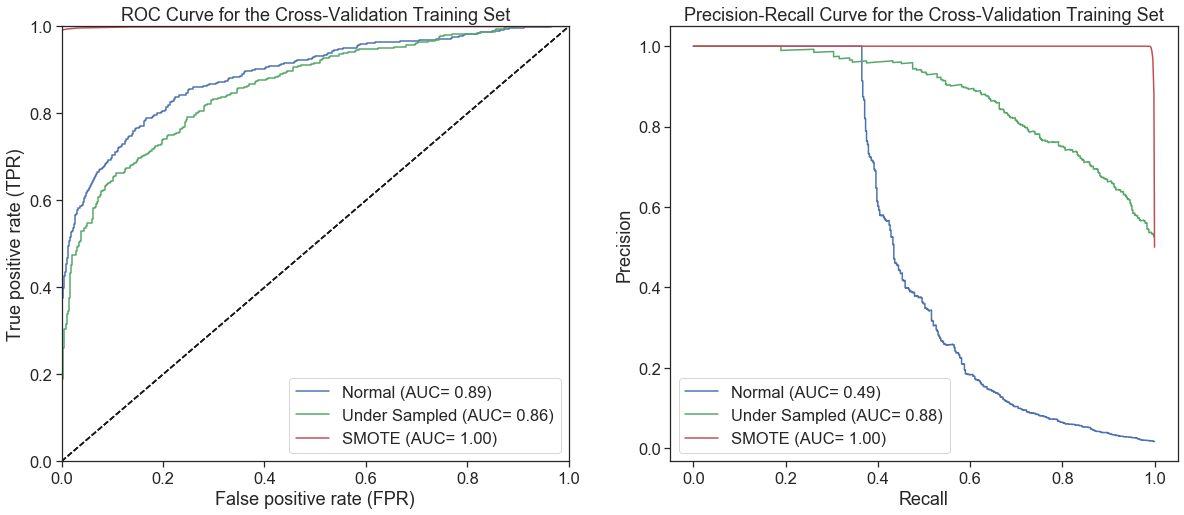

In [44]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR curves for normal imbalanced distribution
Plot_ROC_Curve_and_PRC_Cross_Val(rsearch_rf.best_estimator_, X_train_scale, y_train,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Plot ROC and PR curves for Under Sampled distribution
Plot_ROC_Curve_and_PRC_Cross_Val(rf_und, X_train_scale_und, y_train_und,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')
                     
# Plot ROC and PR curves for SMOTE distribution
Plot_ROC_Curve_and_PRC_Cross_Val(rf_ovsm, X_train_scale_ovsm, y_train_ovsm,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)') 

#  Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## 1. Normal Imbalanced dataset

In [45]:
rf_best = rsearch_rf.best_estimator_
Test_Prediction(rf_best, X_train_scale, y_train, X_test_scale, y_test)

****************************************************************************
Test accuracy:  0.987559
AUROC: 0.861956
AUPRC: 0.500756
Predicted classes: [0 1]
Confusion matrix:
 [[7513    0]
 [  95   28]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7513
           1       1.00      0.23      0.37       123

    accuracy                           0.99      7636
   macro avg       0.99      0.61      0.68      7636
weighted avg       0.99      0.99      0.98      7636

****************************************************************************


## 2. Undersampled dataset

In [46]:
Test_Prediction(rf_und, X_train_scale_und, y_train_und, X_test_scale, y_test)

****************************************************************************
Test accuracy:  0.495285
AUROC: 0.811986
AUPRC: 0.376533
Predicted classes: [0 1]
Confusion matrix:
 [[3678 3835]
 [  19  104]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.49      0.66      7513
           1       0.03      0.85      0.05       123

    accuracy                           0.50      7636
   macro avg       0.51      0.67      0.35      7636
weighted avg       0.98      0.50      0.65      7636

****************************************************************************


## 3. SMOTE dataset

In [47]:
Test_Prediction(rf_ovsm, X_train_scale_ovsm, y_train_ovsm, X_test_scale, y_test)

****************************************************************************
Test accuracy:  0.990309
AUROC: 0.763842
AUPRC: 0.459218
Predicted classes: [0 1]
Confusion matrix:
 [[7512    1]
 [  73   50]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7513
           1       0.98      0.41      0.57       123

    accuracy                           0.99      7636
   macro avg       0.99      0.70      0.78      7636
weighted avg       0.99      0.99      0.99      7636

****************************************************************************


##  ROC and PR Curves on the Test Set
The AUPRC of the normal imbalanced dataset is slightly higher (by 0.01%) than undersampling and SMOTE.

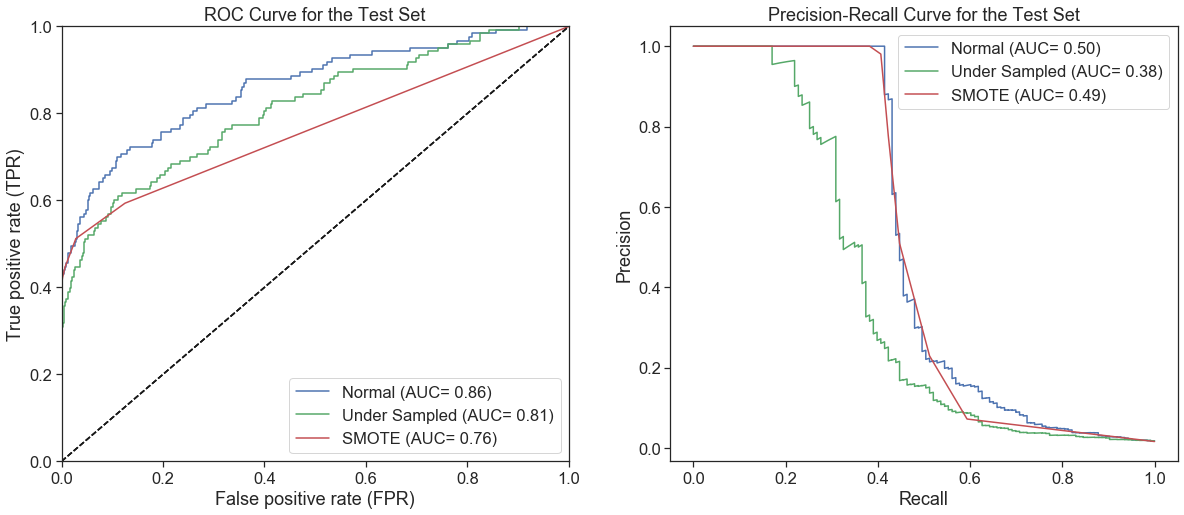

In [48]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR curves for normal imbalanced distribution
Plot_ROC_Curve_and_PRC(rsearch_rf.best_estimator_, X_train_scale, y_train, X_test_scale, y_test,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Plot ROC and PR curves for Under Sampled distribution
Plot_ROC_Curve_and_PRC(rf_und, X_train_scale_und, y_train_und, X_test_scale, y_test,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')

# Plot ROC and PR curves for  SMOTE distribution
Plot_ROC_Curve_and_PRC(rf_ovsm, X_train_scale_ovsm, y_train_ovsm, X_test_scale, y_test,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)')

In [ ]:
# from numbers import Number
# from scipy import stats

# var_list = ['C_YEAR','C_MNTH','C_WDAY','C_HOUR','C_VEHS','C_CONF','C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF',
# 'V_ID','V_TYPE','V_YEAR','P_ID','P_SEX','P_AGE','P_PSN','P_ISEV','P_SAFE','P_USER']
 
# CHI2 = []
# P =[]
# Variable =[]

# for k in var_list:
#     table = pd.crosstab(df['C_SEV'], df[k])
#     chi2, p, dof, expected = stats.chi2_contingency(table.values)
#     Variable.append(k)
#     CHI2.append(chi2)
#     P.append(p)
    
# pd.DataFrame({'Variable': Variable, 'Chi-Square':CHI2, 'P-Value':P })